In [1]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv("/home/delaunan/code/delaunan/clintrialpredict/data/project_data.csv")


In [2]:
data.columns

Index(['nct_id', 'study_type', 'overall_status', 'phase', 'number_of_arms',
       'why_stopped', 'target', 'start_year', 'best_pathology',
       'therapeutic_area', 'therapeutic_subgroup', 'therapeutic_subgroup_name',
       'competition_broad', 'competition_niche', 'gender',
       'healthy_volunteers', 'adult', 'child', 'older_adult',
       'num_primary_endpoints', 'min_p_value', 'phase_ordinal',
       'covid_exposure', 'includes_us', 'is_international', 'agency_class',
       'allocation', 'intervention_model', 'primary_purpose', 'masking',
       'txt_tags', 'txt_criteria'],
      dtype='object')

In [3]:
numeric_df = data.select_dtypes(include=['number'])
numeric_df.columns


Index(['number_of_arms', 'target', 'start_year', 'competition_broad',
       'competition_niche', 'num_primary_endpoints', 'min_p_value',
       'phase_ordinal', 'covid_exposure', 'includes_us', 'is_international'],
      dtype='object')

In [4]:
categorical_cols = data.columns.difference(numeric_df.columns)
categorical_cols

Index(['adult', 'agency_class', 'allocation', 'best_pathology', 'child',
       'gender', 'healthy_volunteers', 'intervention_model', 'masking',
       'nct_id', 'older_adult', 'overall_status', 'phase', 'primary_purpose',
       'study_type', 'therapeutic_area', 'therapeutic_subgroup',
       'therapeutic_subgroup_name', 'txt_criteria', 'txt_tags', 'why_stopped'],
      dtype='object')

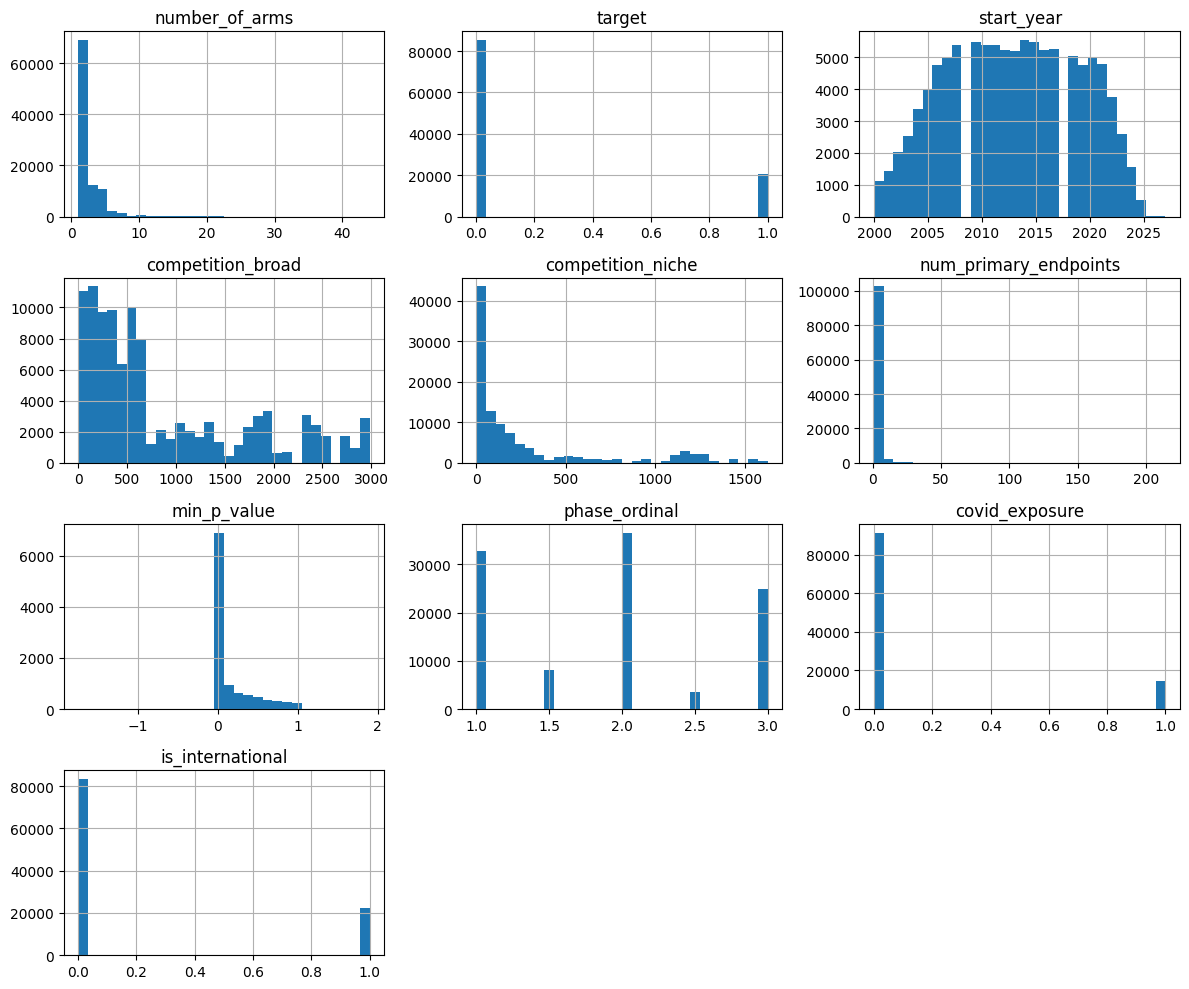

In [ ]:
numeric_df.hist(figsize=(12, 10), bins=30)
plt.tight_layout()
plt.show()

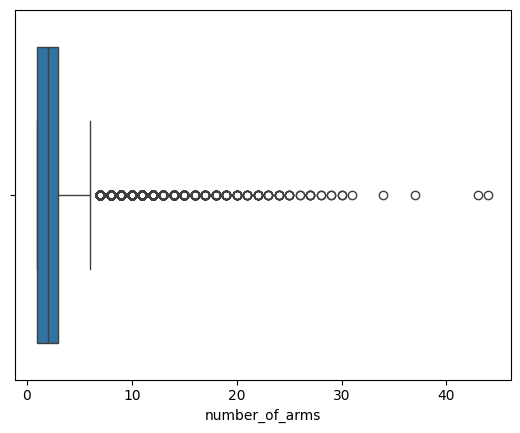

In [5]:
import seaborn as sns
sns.boxplot(x=data["number_of_arms"])
plt.show()


#### So in the distributions, it is visble that:
#### - We can drop target, covid exposure, is_international and min_p_value because they are binary or too many values missing.
#### - competition_niche, competition_broad, num_primary_endpoints, number_of_arms are strongly skewed, long-tailed. So best to Log transform + Standard Scaler (or RobustScaler).
#### - start_year: no skew, bassically symmetric, StandardScaler would be best.
#### - phase_ordinal is not really skewed and do not contain extreme outliers. So MinMax scaling best to keep relative spacing intact.


In [11]:
cols_to_drop = ["target", "covid_exposure", "is_international", "min_p_value"]

num_df = numeric_df.drop(columns=cols_to_drop)


In [12]:
num_df.columns

Index(['number_of_arms', 'start_year', 'competition_broad',
       'competition_niche', 'num_primary_endpoints', 'phase_ordinal',
       'includes_us'],
      dtype='object')

In [13]:
import numpy as np
from sklearn.preprocessing import FunctionTransformer, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, TargetEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

In [21]:
# 1. Define Split Point (80% Train / 20% Test)
# 1. Define Split Point (80% Train / 20% Test)
split_idx = int(len(data) * 0.8)

# 2. Separate Features and Target
X = data.drop(columns=['target', 'overall_status','nct_id'])
y = data['target']

# 3. Perform Temporal Split
X_train = X.iloc[:split_idx]
X_test  = X.iloc[split_idx:]
y_train = y.iloc[:split_idx]
y_test  = y.iloc[split_idx:]

# 4. Extract Years for Post-Hoc Analysis
train_years = X_train['start_year'].values
test_years  = X_test['start_year'].values

In [23]:


#These are the different numeric columns that need to pass through different branches of the pipeline
log_trans_cols = ['competition_niche', 'competition_broad', 'num_primary_endpoints', 'number_of_arms']
stand_scal_cols = ["start_year"]
min_max_cols = ["phase_ordinal"]

cat_binary_cols = ['is_international', 'covid_exposure', 'healthy_volunteers',
              'adult', 'child', 'older_adult', 'includes_us']

cat_nominal_cols = ['gender', 'agency_class', 'masking', 'intervention_model',
               'primary_purpose', 'therapeutic_area', 'allocation']

cat_high_card_cols = ['therapeutic_subgroup_name', 'best_pathology']

pipe_bin = Pipeline([
    ("imputer",SimpleImputer(strategy='most_frequent')),
    ("encoder",OneHotEncoder(drop='if_binary', dtype=int, handle_unknown='ignore'))]
)

pipe_nom = Pipeline([
    ("imputer",SimpleImputer(strategy='constant', fill_value='UNKNOWN')),
    ("hot_encoder", OneHotEncoder(handle_unknown='ignore', sparse_output=False, dtype=int))]
)

pipe_high = Pipeline([
    ("imputer",SimpleImputer(strategy='constant', fill_value='UNKNOWN')),
    ("target",TargetEncoder(target_type='binary', smooth=10.0, random_state=42))]
)

#Pipeline for highly skewed columns
log_std_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("log1p", FunctionTransformer(np.log1p, validate=False)),
    ("scaler", StandardScaler())])

#Pipeline for StandardScaling
std_pipeline = Pipeline([
     ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())])

#Pipeline for MinMax Scaling
minmax_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("scaler", MinMaxScaler())])

scaler = ColumnTransformer(
    transformers=[
        ("log_std", log_std_pipeline, log_trans_cols),
        ("std", std_pipeline, stand_scal_cols),
        ("minmax", minmax_pipeline, min_max_cols),
        ("cat_binary", pipe_bin,cat_binary_cols),
        ("nominal", pipe_nom,cat_nominal_cols),
        ("high_card", pipe_high,cat_high_card_cols)],remainder="drop")


In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

log_reg_model = Pipeline(steps=[
    ("preprocess", scaler),
    ("model", LogisticRegression(class_weight='balanced', solver='liblinear', penalty='l2', C=0.01,max_iter=1000, random_state=42))])

log_reg_model.fit(X_train, y_train)
log_reg_model.predict(X_test)


array([1, 0, 0, ..., 1, 1, 1])

--- MODEL PERFORMANCE METRICS ---
ROC-AUC Score:      0.7036  (0.5 = Random, 1.0 = Perfect)
PR-AUC Score:       0.3692   (Baseline: 0.1914)
----------------------------------------
CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.89      0.61      0.72     17035
           1       0.29      0.68      0.41      4033

    accuracy                           0.62     21068
   macro avg       0.59      0.64      0.57     21068
weighted avg       0.77      0.62      0.66     21068



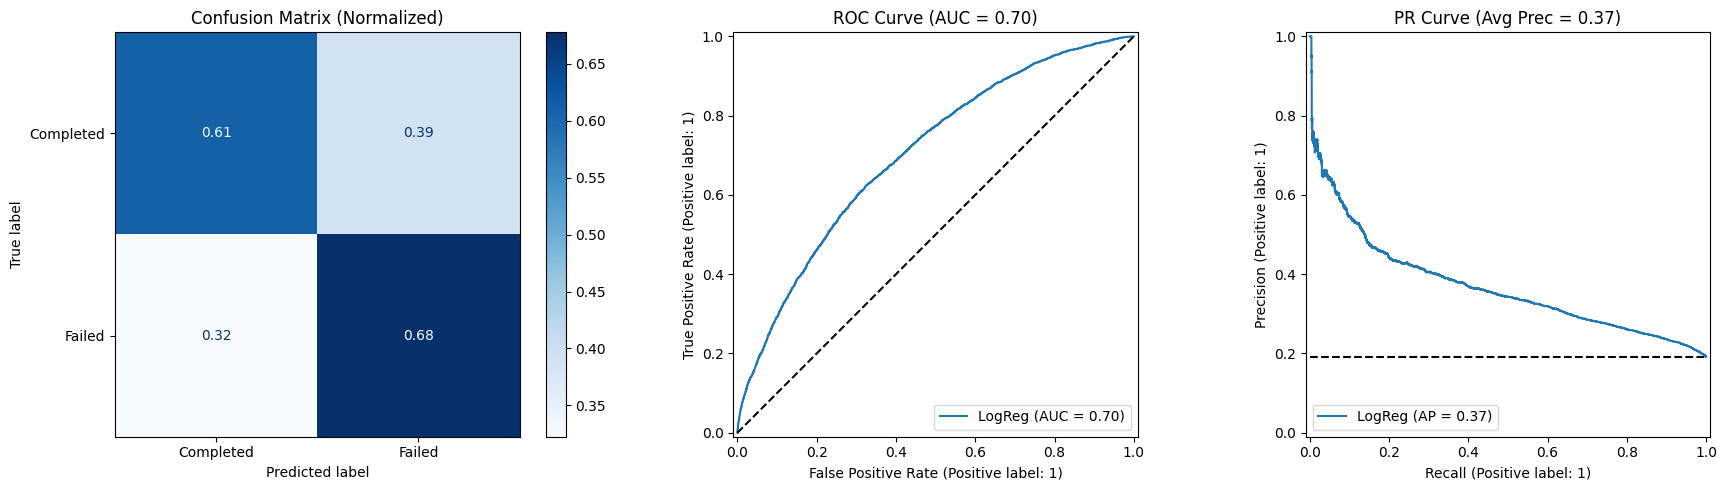

In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    classification_report,
    ConfusionMatrixDisplay,
    RocCurveDisplay,
    PrecisionRecallDisplay
)

# 1. Get Predictions (Probabilities are crucial for Risk Scoring)
y_pred = log_reg_model.predict(X_test)
y_prob = log_reg_model.predict_proba(X_test)[:, 1]  # Probability of Class 1 (Failure)

# 2. Calculate Key Metrics
roc_score = roc_auc_score(y_test, y_prob)
pr_score = average_precision_score(y_test, y_prob)

print(f"--- MODEL PERFORMANCE METRICS ---")
print(f"ROC-AUC Score:      {roc_score:.4f}  (0.5 = Random, 1.0 = Perfect)")
print(f"PR-AUC Score:       {pr_score:.4f}   (Baseline: {y_test.mean():.4f})")
print("-" * 40)
print("CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred))

# 3. Visualizations (The "Truth" Charts)
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# A. Confusion Matrix (Normalized to show percentages)
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    normalize='true',
    cmap='Blues',
    display_labels=['Completed', 'Failed'],
    ax=ax[0]
)
ax[0].set_title("Confusion Matrix (Normalized)")

# B. ROC Curve (Trade-off between TP and FP)
RocCurveDisplay.from_predictions(y_test, y_prob, ax=ax[1], name='LogReg')
ax[1].set_title(f"ROC Curve (AUC = {roc_score:.2f})")
ax[1].plot([0, 1], [0, 1], "k--", label="Chance") # Add diagonal line

# C. Precision-Recall Curve (Best for Imbalanced Data)
PrecisionRecallDisplay.from_predictions(y_test, y_prob, ax=ax[2], name='LogReg')
ax[2].set_title(f"PR Curve (Avg Prec = {pr_score:.2f})")
ax[2].plot([0, 1], [y_test.mean(), y_test.mean()], "k--", label="Baseline") # Add baseline

plt.tight_layout()
plt.show()

In [26]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, classification_report

# 1. Create the "Dumb" Model
# strategy='most_frequent' means "Always predict the majority class (0)"
dummy = DummyClassifier(strategy='most_frequent')

# 2. Fit (It just looks at the counts of 0 vs 1)
dummy.fit(X_train, y_train)

# 3. Predict
y_pred_dummy = dummy.predict(X_test)

# 4. Evaluate
print(f"Dumb Model Accuracy: {accuracy_score(y_test, y_pred_dummy):.4f}")
print("\nClassification Report (Notice Class 1 is 0.00):")
print(classification_report(y_test, y_pred_dummy, zero_division=0))

Dumb Model Accuracy: 0.8086

Classification Report (Notice Class 1 is 0.00):
              precision    recall  f1-score   support

           0       0.81      1.00      0.89     17035
           1       0.00      0.00      0.00      4033

    accuracy                           0.81     21068
   macro avg       0.40      0.50      0.45     21068
weighted avg       0.65      0.81      0.72     21068



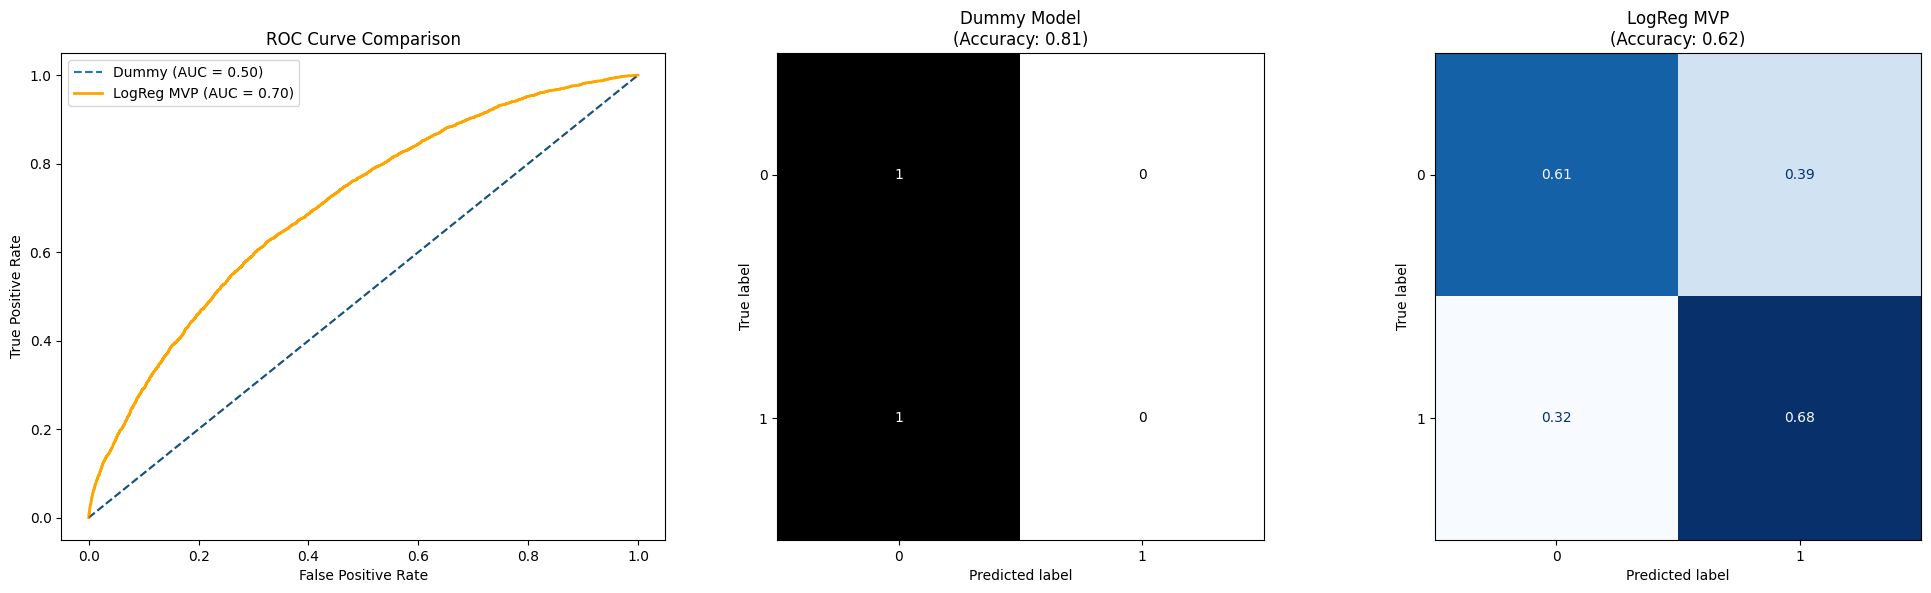

In [28]:
import matplotlib.pyplot as plt
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

# -----------------------------------------------------------------------------
# 1. TRAIN DUMMY CLASSIFIER
# -----------------------------------------------------------------------------
# Strategy 'most_frequent' always predicts Class 0 (Completed)
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, y_train)

# Get Predictions
y_pred_dummy = dummy.predict(X_test)
y_prob_dummy = dummy.predict_proba(X_test)[:, 1] # Usually all zeros

# Get MVP Predictions (from your existing log_reg_model)
y_pred_mvp = log_reg_model.predict(X_test)
y_prob_mvp = log_reg_model.predict_proba(X_test)[:, 1]

# -----------------------------------------------------------------------------
# 2. VISUAL COMPARISON
# -----------------------------------------------------------------------------
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

# --- Plot A: ROC Curves ---
fpr_d, tpr_d, _ = roc_curve(y_test, y_prob_dummy)
fpr_m, tpr_m, _ = roc_curve(y_test, y_prob_mvp)

ax[0].plot(fpr_d, tpr_d, linestyle='--', label=f'Dummy (AUC = 0.50)')
ax[0].plot(fpr_m, tpr_m, linewidth=2, color='orange', label=f'LogReg MVP (AUC = {roc_auc_score(y_test, y_prob_mvp):.2f})')
ax[0].plot([0, 1], [0, 1], 'k--', alpha=0.3)
ax[0].set_title("ROC Curve Comparison")
ax[0].set_xlabel("False Positive Rate")
ax[0].set_ylabel("True Positive Rate")
ax[0].legend()

# --- Plot B: Dummy Confusion Matrix ---
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_dummy,
    normalize='true', cmap='Greys', colorbar=False, ax=ax[1]
)
ax[1].set_title(f"Dummy Model\n(Accuracy: {dummy.score(X_test, y_test):.2f})")

# --- Plot C: MVP Confusion Matrix ---
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_mvp,
    normalize='true', cmap='Blues', colorbar=False, ax=ax[2]
)
ax[2].set_title(f"LogReg MVP\n(Accuracy: {log_reg_model.score(X_test, y_test):.2f})")

plt.tight_layout()
plt.show()

In [29]:
from xgboost import XGBClassifier

# Calculate the ratio for scale_pos_weight
# (Count of Negatives / Count of Positives)
ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)

xgb_model = Pipeline(steps=[
    ("preprocess", scaler), # Keep your existing scaler!
    ("model", XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        scale_pos_weight=ratio, # This replaces class_weight='balanced'
        eval_metric='logloss',
        random_state=42,
        n_jobs=-1
    ))
])

print(f"Training XGBoost with scale_pos_weight={ratio:.2f}...")
xgb_model.fit(X_train, y_train)

# Evaluate
print("XGBoost ROC-AUC:", roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:, 1]))

Training XGBoost with scale_pos_weight=4.16...
XGBoost ROC-AUC: 0.7255317318648884


>>> Training Models...


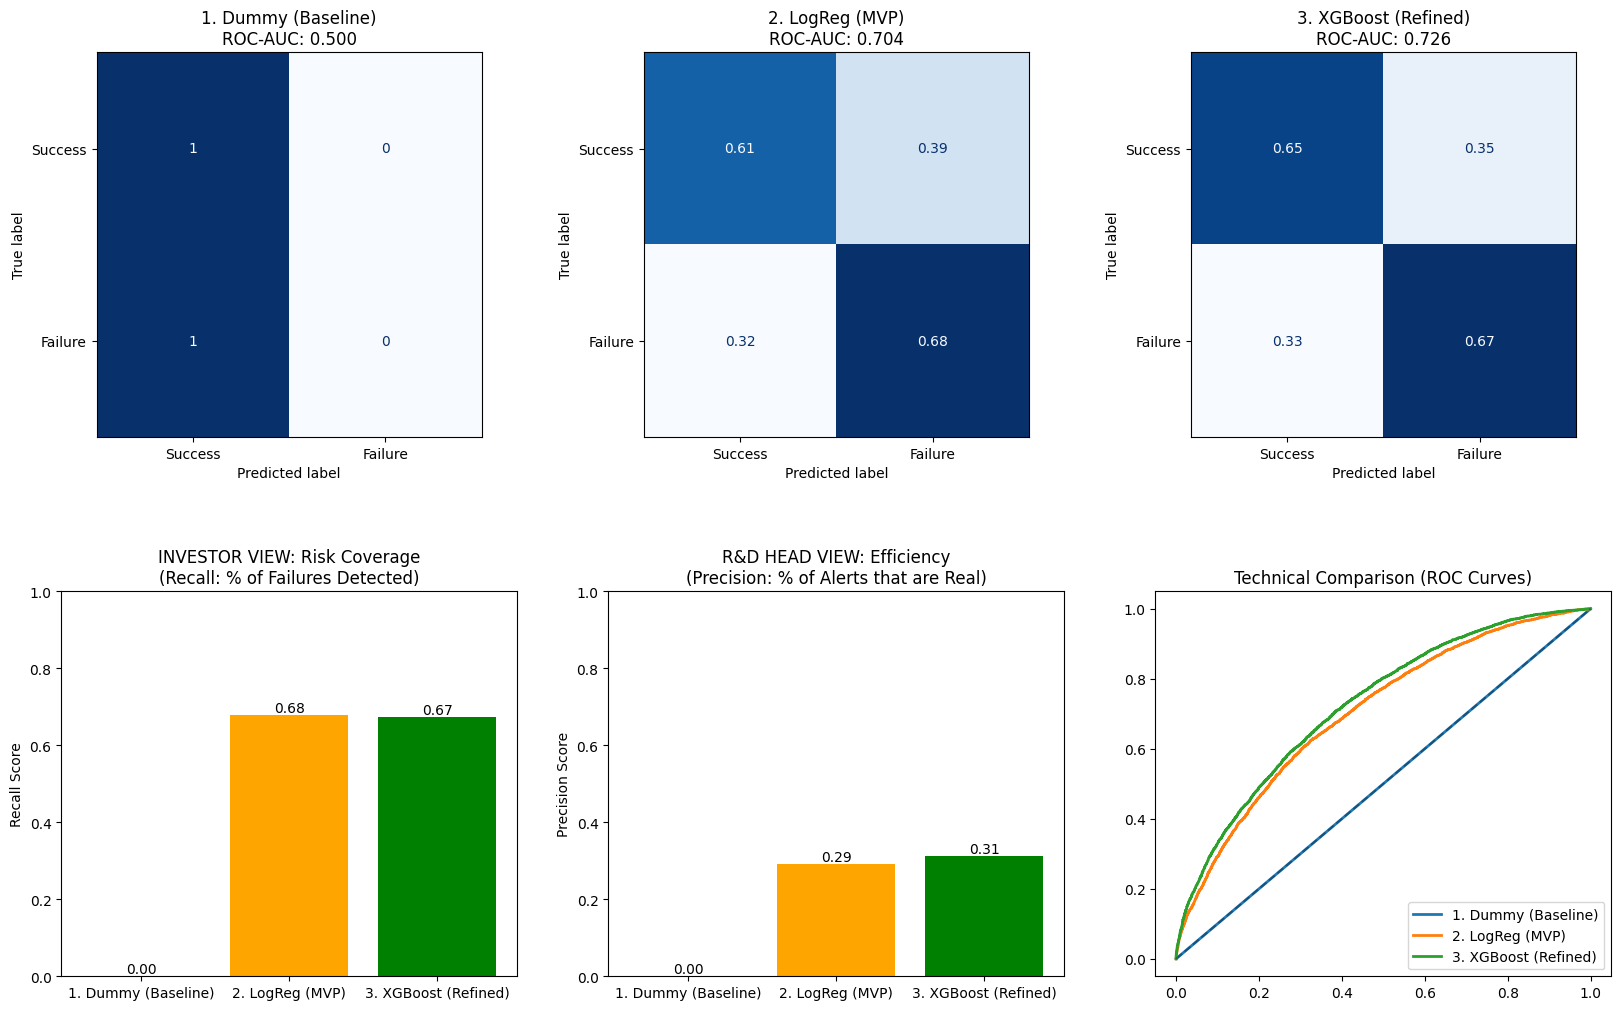


EXECUTIVE SUMMARY & RECOMMENDATION
1. INVESTOR TAKEAWAY (Risk Aversion):
   - Focus on RECALL (Did we catch the failures?)
   - LogReg Recall: 67.7%
   - XGBoost Recall: 67.3%
   > Insight: If LogReg is higher, it is 'safer' but flags more false alarms.

2. R&D HEAD TAKEAWAY (Efficiency):
   - Focus on PRECISION (Are we wasting time on false alarms?)
   - LogReg Precision: 29.2%
   - XGBoost Precision: 31.1%
   > Insight: XGBoost usually offers better Precision, reducing 'Alert Fatigue'.

3. WINNER: XGBoost


In [30]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, recall_score, precision_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve

# -----------------------------------------------------------------------------
# 1. TRAIN THE THREE MODELS
# -----------------------------------------------------------------------------
print(">>> Training Models...")

# A. DUMMY (The Floor)
dummy_model = DummyClassifier(strategy='most_frequent')
dummy_model.fit(X_train, y_train)

# B. LOGISTIC REGRESSION (The Baseline)
# Note: We use the 'scaler' defined in your previous block
log_model = Pipeline(steps=[
    ("preprocess", scaler),
    ("model", LogisticRegression(class_weight='balanced', solver='liblinear', C=0.01, random_state=42))
])
log_model.fit(X_train, y_train)

# C. XGBOOST (The Challenger)
# Calculate scale_pos_weight for imbalance
ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)

xgb_model = Pipeline(steps=[
    ("preprocess", scaler),
    ("model", XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1,
                            scale_pos_weight=ratio, random_state=42, n_jobs=-1))
])
xgb_model.fit(X_train, y_train)

# -----------------------------------------------------------------------------
# 2. GENERATE PREDICTIONS
# -----------------------------------------------------------------------------
models = {
    "1. Dummy (Baseline)": dummy_model,
    "2. LogReg (MVP)": log_model,
    "3. XGBoost (Refined)": xgb_model
}

results = {}
for name, model in models.items():
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    results[name] = {
        "pred": y_pred,
        "prob": y_prob,
        "roc": roc_auc_score(y_test, y_prob),
        "recall": recall_score(y_test, y_pred),      # Investor KPI
        "precision": precision_score(y_test, y_pred, zero_division=0) # R&D KPI
    }

# -----------------------------------------------------------------------------
# 3. VISUALIZATION DASHBOARD
# -----------------------------------------------------------------------------
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
plt.subplots_adjust(hspace=0.4)

# ROW 1: CONFUSION MATRICES (The Truth)
for i, (name, res) in enumerate(results.items()):
    ax = axes[0, i]
    ConfusionMatrixDisplay.from_predictions(
        y_test, res['pred'],
        normalize='true', cmap='Blues', colorbar=False, ax=ax,
        display_labels=['Success', 'Failure']
    )
    ax.set_title(f"{name}\nROC-AUC: {res['roc']:.3f}")

# ROW 2: STAKEHOLDER KPIs
# We create a bar chart comparing the metrics that matter to each person
names = list(results.keys())
recalls = [results[n]['recall'] for n in names]
precisions = [results[n]['precision'] for n in names]

# Plot A: Investor View (Recall)
ax_inv = axes[1, 0]
bars = ax_inv.bar(names, recalls, color=['gray', 'orange', 'green'])
ax_inv.set_title("INVESTOR VIEW: Risk Coverage\n(Recall: % of Failures Detected)")
ax_inv.set_ylim(0, 1)
ax_inv.bar_label(bars, fmt='%.2f')
ax_inv.set_ylabel("Recall Score")

# Plot B: R&D Head View (Precision)
ax_rnd = axes[1, 1]
bars = ax_rnd.bar(names, precisions, color=['gray', 'orange', 'green'])
ax_rnd.set_title("R&D HEAD VIEW: Efficiency\n(Precision: % of Alerts that are Real)")
ax_rnd.set_ylim(0, 1)
ax_rnd.bar_label(bars, fmt='%.2f')
ax_rnd.set_ylabel("Precision Score")

# Plot C: ROC Curves Overlay
ax_roc = axes[1, 2]
for name, res in results.items():
    fpr, tpr, _ = roc_curve(y_test, res['prob'])
    ax_roc.plot(fpr, tpr, linewidth=2, label=f"{name}")
ax_roc.plot([0, 1], [0, 1], 'k--', alpha=0.3)
ax_roc.set_title("Technical Comparison (ROC Curves)")
ax_roc.legend(loc='lower right')

plt.show()

# -----------------------------------------------------------------------------
# 4. TEXT REPORT
# -----------------------------------------------------------------------------
print("\n" + "="*60)
print("EXECUTIVE SUMMARY & RECOMMENDATION")
print("="*60)
best_model = "XGBoost" if results["3. XGBoost (Refined)"]["roc"] > results["2. LogReg (MVP)"]["roc"] else "LogReg"

print(f"1. INVESTOR TAKEAWAY (Risk Aversion):")
print(f"   - Focus on RECALL (Did we catch the failures?)")
print(f"   - LogReg Recall: {results['2. LogReg (MVP)']['recall']:.1%}")
print(f"   - XGBoost Recall: {results['3. XGBoost (Refined)']['recall']:.1%}")
print(f"   > Insight: If LogReg is higher, it is 'safer' but flags more false alarms.")

print(f"\n2. R&D HEAD TAKEAWAY (Efficiency):")
print(f"   - Focus on PRECISION (Are we wasting time on false alarms?)")
print(f"   - LogReg Precision: {results['2. LogReg (MVP)']['precision']:.1%}")
print(f"   - XGBoost Precision: {results['3. XGBoost (Refined)']['precision']:.1%}")
print(f"   > Insight: XGBoost usually offers better Precision, reducing 'Alert Fatigue'.")

print(f"\n3. WINNER: {best_model}")
print("="*60)

In [ ]:
xgboost_model

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['number_of_arms', 'target',
                                                   'start_year',
                                                   'competition_broad',
                                                   'competition_niche',
                                                   'num_primary_endpoints',
                                                   'min_p_value',
                                                   'phase_ordinal',
                                                   'covid_exposure',
                                                   'is_international']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['adult', 'agency_class', 'allocation', 'best_...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None, min_child_weight=5,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=2000,
                               n_jobs=-1, num_parallel_tree=None,
                               random_state=42, ...))])